**102 Final Project EDA CHECKPOINT 1**

**1. Visualizations**
- Heat Map 
- Scatter Plot 


**2. Trends & Relationships**
- Illinois Indiana Ohio and Kentucky have consistently poor air quality ratings - through all the years observed 
- California and other states in the West start off with fairly good ratings and get progressively worse as time goes on (with some exceptions; 2011-2012 it gets worse again before getting better.) 
- Wyoming is the only state to have an average of lower than  pm2.5 level in 2014 
- We would also like to further follow up on the slight positive relationship between pm2.5 levels and asthma mortality rates.


**3. Data Cleaning Steps**
- Filter asthma dataset for the same years as the pm2.5 dataset (2011-2014)
- Filter asthma dataset for DataValueType == ‘Number’
- Drop blank rows for DataValue in asthma dataset
- Adjust state abbreviation strings so that all tables have the same format
- Group pm2.5 dataset by year and state
- Join both tables by state (had to use an external dataset that mapped state abbreviations to state ids)

These decisions will impact our models and inferences as they will only be valid for the years 2011 through 2014, and they will only apply to the number of asthma cases. Also, when we grouped pm2.5 by year and state, we took the average of the pm2.5 levels. Taking the average of this value reduces the variance in our models.



**4. Visualization Relevance:** 
The scatter plot shows that we have a positive (if weak) relationship between Asthma mortality and PM2.5 levels. The map choropleth shows us which states have changing levels of PM2.5 and which have consistently poor levels. This may become important when we choose which area or areas to focus on, or how to account for confounding variables.


In [2]:
import numpy as np
import pandas as pd
# from google.colab import drive
import plotly.express as px
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn import metrics

In [2]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
df1 = pd.read_csv('/content/drive/MyDrive/Data102-Group-Project/pm25_grouped_by_year_and_state.csv')
df2 = pd.read_csv('/content/drive/MyDrive/Data102-Group-Project/U.S._Chronic_Disease_Indicators__Asthma.csv')
state_ids = pd.read_csv('/content/drive/MyDrive/Data102-Group-Project/stateids.tsv', delimiter='\t', header=None)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
df1 = pd.read_csv('pm25_grouped_by_year_and_state.csv')
df2 = pd.read_csv('U.S._Chronic_Disease_Indicators__Asthma.csv')
state_ids = pd.read_csv('stateids.tsv', delimiter='\t', header=None)

In [4]:
state_ids = state_ids.append([['District of Columbia', 'DC', 11]]).reset_index(drop=True)

C:\Users\afros\AppData\Local\Temp\ipykernel_59012\3664118970.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  state_ids = state_ids.append([['District of Columbia', 'DC', 11]]).reset_index(drop=True)


In [5]:
df2 = df2.drop(columns = ['Response', 'DataValueUnit', 'StratificationCategory2','Stratification2', 'StratificationCategory3', 'Stratification3', 'ResponseID', 'StratificationID1', 'StratificationCategoryID2', 'StratificationID2', 'StratificationCategoryID3', 'StratificationID3'])

In [6]:
df2 = df2[((df2.YearEnd >= 2011) & (df2.YearEnd <= 2014))]

In [7]:
code_book = {}
for state, number in zip(state_ids[1].tolist(), state_ids[2].tolist()):
    code_book[number] = state

In [8]:
df1['LocationAbbr'] = df1['statefips'].map(code_book)

In [9]:
fix_location = []
for entry in df2.LocationAbbr:
    if entry != np.nan:
        entry = entry.replace(' ', '')
    fix_location.append(entry)
df2['LocationAbbr'] = fix_location

In [10]:
fix_location = []
for entry in df1.LocationAbbr:
    if entry != np.nan:
        entry = str(entry).replace(' ', '')
    fix_location.append(entry)
df1['LocationAbbr'] = fix_location

In [11]:
df3 = df2.set_index('LocationAbbr').merge(df1.set_index('LocationAbbr'), left_on=['LocationAbbr', 'YearStart'], right_on=['LocationAbbr', 'year'], how='inner').reset_index()

In [12]:
# df4 = df3[['LocationAbbr', 'YearStart', 'ds_pm_pred']]
# df4 = df4.sort_values('YearStart')

In [13]:
# fig = px.choropleth(df4,
#                     locations='LocationAbbr', 
#                     locationmode="USA-states", 
#                     scope="usa",
#                     color='ds_pm_pred',
#                     color_continuous_scale="Viridis_r",
#                     animation_frame='YearStart'
#                     )
# fig.show()

In [14]:
df4 = df3[df3['Question'] == 'Asthma mortality rate']
df4 = df4[df4['DataValue'].isna() == False]
df4 = df4[df4['DataValueType'] == 'Number']

In [15]:
df4 = df4.drop(['YearEnd', 'year', 'Topic', 'DataSource','DataValueType', 'DataValueAlt', 'DataValueFootnoteSymbol', 
          'DatavalueFootnote', 'TopicID', 'QuestionID', 'StratificationCategory1', 'DataValueTypeID',
          'StratificationCategoryID1', 'LocationDesc', 'statefips', 'LowConfidenceLimit', 'HighConfidenceLimit'], axis=1).reset_index(drop=True)

In [16]:
df5 = pd.get_dummies(df4, columns = ['Stratification1'])

In [17]:
df5.head()

,LocationAbbr,YearStart,Question,DataValue,LocationID,ds_pm_pred,Stratification1_Asian or Pacific Islander,"Stratification1_Black, non-Hispanic",Stratification1_Female,Stratification1_Hispanic,Stratification1_Male,Stratification1_Overall,"Stratification1_White, non-Hispanic"
0,AZ,2014,Asthma mortality rate,86.0,4,7.573242,0,0,0,0,0,1,0
1,AZ,2014,Asthma mortality rate,33.0,4,7.573242,0,0,0,0,1,0,0
2,AZ,2014,Asthma mortality rate,60.0,4,7.573242,0,0,0,0,0,0,1
3,AZ,2014,Asthma mortality rate,53.0,4,7.573242,0,0,1,0,0,0,0
4,GA,2014,Asthma mortality rate,58.0,13,10.808668,0,0,1,0,0,0,0


In [30]:
# for causal inference 
def fit_OLS_model(df, target_variable, explanatory_variables, intercept = False):
    """
    Fits an OLS model from data.
    
    Inputs:
        df: pandas DataFrame
        target_variable: string, name of the target variable
        explanatory_variables: list of strings, names of the explanatory variables
        intercept: bool, if True add intercept term
    Outputs:
        fitted_model: model containing OLS regression results
    """
    
    target = df[target_variable]
    inputs = df[explanatory_variables]
    if intercept:
        inputs = sm.add_constant(inputs)
    
    fitted_model = sm.OLS(target, inputs).fit()
    return(fitted_model)

In [31]:
all_col = np.delete(np.array(df5.columns), [0, 2, 3, 6, 7, 9, 10, 11, 12])
all_col

array(['YearStart', 'LocationID', 'statefips',
       'Stratification1_Black, non-Hispanic',
       'Stratification1_White, non-Hispanic'], dtype=object)

Below are the diff analyses:
0. DataValue vs pm level
1. DataValue vs LocationID
2. DataValue vs YearStart
3. DataValue vs Female
4. DataValue vs [pm levels, LocationID]
5. DataValue vs [pm levels, YearStart]
6. DataValue vs [pm levels, Female]
7. DataValue vs [LocationID, YearStart]
8. DataValue vs [LocationID, Female]
9. DataValue vs [YearStart, Female]
10. DataValue vs [pm levels, LocationID, YearStart]
11. DataValue vs [pm levels, LocationID, Female]
12. DataValue vs [pm levels, YearStart, Female]
13. DataValue vs [LocationID, YearStart, Female]
14. DataValue vs [pm levels, LocationID, YearStart, Female]

## Single Parameter (with DataValue)
* Maybe look at relationship among different explanatory variables? (Location vs pm levels)
* Also, we have not considered race here so idk if thats something else we wanna explore here?

In [ ]:
gammas_model = fit_OLS_model(df5, 'DataValue', 'ds_pm_pred')
print(gammas_model.summary())

                                 OLS Regression Results                                
Dep. Variable:              DataValue   R-squared (uncentered):                   0.598
Model:                            OLS   Adj. R-squared (uncentered):              0.597
Method:                 Least Squares   F-statistic:                              909.1
Date:                Mon, 02 May 2022   Prob (F-statistic):                   4.92e-123
Time:                        19:36:23   Log-Likelihood:                         -3280.9
No. Observations:                 612   AIC:                                      6564.
Df Residuals:                     611   BIC:                                      6568.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [ ]:
gammas_model1 = fit_OLS_model(df5, 'DataValue', 'LocationID')
print(gammas_model1.summary())

                                 OLS Regression Results                                
Dep. Variable:              DataValue   R-squared (uncentered):                   0.433
Model:                            OLS   Adj. R-squared (uncentered):              0.432
Method:                 Least Squares   F-statistic:                              465.9
Date:                Mon, 02 May 2022   Prob (F-statistic):                    3.10e-77
Time:                        19:36:23   Log-Likelihood:                         -3386.4
No. Observations:                 612   AIC:                                      6775.
Df Residuals:                     611   BIC:                                      6779.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [ ]:
gammas_model2 = fit_OLS_model(df5, 'DataValue', 'YearStart')
print(gammas_model2.summary())

                                 OLS Regression Results                                
Dep. Variable:              DataValue   R-squared (uncentered):                   0.590
Model:                            OLS   Adj. R-squared (uncentered):              0.589
Method:                 Least Squares   F-statistic:                              878.9
Date:                Mon, 02 May 2022   Prob (F-statistic):                   2.29e-120
Time:                        19:36:24   Log-Likelihood:                         -3287.1
No. Observations:                 612   AIC:                                      6576.
Df Residuals:                     611   BIC:                                      6581.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [ ]:
gammas_model3 = fit_OLS_model(df5, 'DataValue', 'Stratification1_Female')
print(gammas_model3.summary())

                                 OLS Regression Results                                
Dep. Variable:              DataValue   R-squared (uncentered):                   0.123
Model:                            OLS   Adj. R-squared (uncentered):              0.122
Method:                 Least Squares   F-statistic:                              86.03
Date:                Mon, 02 May 2022   Prob (F-statistic):                    3.02e-19
Time:                        19:36:24   Log-Likelihood:                         -3519.5
No. Observations:                 612   AIC:                                      7041.
Df Residuals:                     611   BIC:                                      7045.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

## Two Parameters (with DataValue)

### with pm level

In [ ]:
gammas_model4 = fit_OLS_model(df5, 'DataValue', ['ds_pm_pred', 'LocationID'])
print(gammas_model4.summary())

                                 OLS Regression Results                                
Dep. Variable:              DataValue   R-squared (uncentered):                   0.599
Model:                            OLS   Adj. R-squared (uncentered):              0.598
Method:                 Least Squares   F-statistic:                              456.1
Date:                Mon, 02 May 2022   Prob (F-statistic):                   7.58e-122
Time:                        19:36:24   Log-Likelihood:                         -3280.0
No. Observations:                 612   AIC:                                      6564.
Df Residuals:                     610   BIC:                                      6573.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [ ]:
gammas_model5 = fit_OLS_model(df5, 'DataValue', ['ds_pm_pred', 'YearStart'])
print(gammas_model5.summary())

                                 OLS Regression Results                                
Dep. Variable:              DataValue   R-squared (uncentered):                   0.598
Model:                            OLS   Adj. R-squared (uncentered):              0.597
Method:                 Least Squares   F-statistic:                              454.0
Date:                Mon, 02 May 2022   Prob (F-statistic):                   1.70e-121
Time:                        19:36:24   Log-Likelihood:                         -3280.8
No. Observations:                 612   AIC:                                      6566.
Df Residuals:                     610   BIC:                                      6574.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [ ]:
gammas_model6 = fit_OLS_model(df5, 'DataValue', ['ds_pm_pred', 'Stratification1_Female'])
print(gammas_model6.summary())

                                 OLS Regression Results                                
Dep. Variable:              DataValue   R-squared (uncentered):                   0.598
Model:                            OLS   Adj. R-squared (uncentered):              0.597
Method:                 Least Squares   F-statistic:                              453.8
Date:                Mon, 02 May 2022   Prob (F-statistic):                   1.86e-121
Time:                        19:36:26   Log-Likelihood:                         -3280.9
No. Observations:                 612   AIC:                                      6566.
Df Residuals:                     610   BIC:                                      6575.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

### with LocationID

In [ ]:
gammas_model7 = fit_OLS_model(df5, 'DataValue', ['LocationID', 'YearStart'])
print(gammas_model7.summary())

                                 OLS Regression Results                                
Dep. Variable:              DataValue   R-squared (uncentered):                   0.591
Model:                            OLS   Adj. R-squared (uncentered):              0.590
Method:                 Least Squares   F-statistic:                              441.5
Date:                Mon, 02 May 2022   Prob (F-statistic):                   2.74e-119
Time:                        19:36:26   Log-Likelihood:                         -3285.9
No. Observations:                 612   AIC:                                      6576.
Df Residuals:                     610   BIC:                                      6585.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [ ]:
gammas_model8 = fit_OLS_model(df5, 'DataValue', ['LocationID','Stratification1_Female'])
print(gammas_model8.summary())

                                 OLS Regression Results                                
Dep. Variable:              DataValue   R-squared (uncentered):                   0.442
Model:                            OLS   Adj. R-squared (uncentered):              0.440
Method:                 Least Squares   F-statistic:                              241.3
Date:                Mon, 02 May 2022   Prob (F-statistic):                    6.18e-78
Time:                        19:36:26   Log-Likelihood:                         -3381.4
No. Observations:                 612   AIC:                                      6767.
Df Residuals:                     610   BIC:                                      6776.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

### with YearStart

In [ ]:
gammas_model9 = fit_OLS_model(df5, 'DataValue', ['YearStart','Stratification1_Female'])
print(gammas_model9.summary())

                                 OLS Regression Results                                
Dep. Variable:              DataValue   R-squared (uncentered):                   0.590
Model:                            OLS   Adj. R-squared (uncentered):              0.589
Method:                 Least Squares   F-statistic:                              438.7
Date:                Mon, 02 May 2022   Prob (F-statistic):                   8.52e-119
Time:                        19:36:26   Log-Likelihood:                         -3287.1
No. Observations:                 612   AIC:                                      6578.
Df Residuals:                     610   BIC:                                      6587.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

## Three parameters (with DataValue)

### with pm levels

In [ ]:
gammas_model10 = fit_OLS_model(df5, 'DataValue', ['ds_pm_pred', 'LocationID' , 'YearStart'])
print(gammas_model10.summary())

                                 OLS Regression Results                                
Dep. Variable:              DataValue   R-squared (uncentered):                   0.600
Model:                            OLS   Adj. R-squared (uncentered):              0.598
Method:                 Least Squares   F-statistic:                              304.0
Date:                Mon, 02 May 2022   Prob (F-statistic):                   1.35e-120
Time:                        19:36:26   Log-Likelihood:                         -3279.7
No. Observations:                 612   AIC:                                      6565.
Df Residuals:                     609   BIC:                                      6579.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [ ]:
gammas_model11 = fit_OLS_model(df5, 'DataValue', ['ds_pm_pred', 'LocationID' , 'Stratification1_Female'])
print(gammas_model11.summary())

                                 OLS Regression Results                                
Dep. Variable:              DataValue   R-squared (uncentered):                   0.599
Model:                            OLS   Adj. R-squared (uncentered):              0.597
Method:                 Least Squares   F-statistic:                              303.5
Date:                Mon, 02 May 2022   Prob (F-statistic):                   1.83e-120
Time:                        19:36:26   Log-Likelihood:                         -3280.0
No. Observations:                 612   AIC:                                      6566.
Df Residuals:                     609   BIC:                                      6579.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

In [ ]:
gammas_model12 = fit_OLS_model(df5, 'DataValue', ['ds_pm_pred', 'YearStart' , 'Stratification1_Female'])
print(gammas_model12.summary())

                                 OLS Regression Results                                
Dep. Variable:              DataValue   R-squared (uncentered):                   0.598
Model:                            OLS   Adj. R-squared (uncentered):              0.596
Method:                 Least Squares   F-statistic:                              302.2
Date:                Mon, 02 May 2022   Prob (F-statistic):                   4.08e-120
Time:                        19:36:26   Log-Likelihood:                         -3280.8
No. Observations:                 612   AIC:                                      6568.
Df Residuals:                     609   BIC:                                      6581.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

### with LocationID

In [ ]:
gammas_model13 = fit_OLS_model(df5, 'DataValue', ['LocationID' , 'YearStart','Stratification1_Female'])
print(gammas_model13.summary())

                                 OLS Regression Results                                
Dep. Variable:              DataValue   R-squared (uncentered):                   0.591
Model:                            OLS   Adj. R-squared (uncentered):              0.589
Method:                 Least Squares   F-statistic:                              293.9
Date:                Mon, 02 May 2022   Prob (F-statistic):                   6.48e-118
Time:                        19:36:26   Log-Likelihood:                         -3285.9
No. Observations:                 612   AIC:                                      6578.
Df Residuals:                     609   BIC:                                      6591.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

## Four parameters (with DataValue)

In [ ]:
gammas_model14 = fit_OLS_model(df5, 'DataValue', ['ds_pm_pred', 'LocationID' , 'YearStart','Stratification1_Female'])
print(gammas_model14.summary())

                                 OLS Regression Results                                
Dep. Variable:              DataValue   R-squared (uncentered):                   0.600
Model:                            OLS   Adj. R-squared (uncentered):              0.597
Method:                 Least Squares   F-statistic:                              227.7
Date:                Mon, 02 May 2022   Prob (F-statistic):                   2.55e-119
Time:                        19:36:27   Log-Likelihood:                         -3279.7
No. Observations:                 612   AIC:                                      6567.
Df Residuals:                     608   BIC:                                      6585.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

## Visualizations

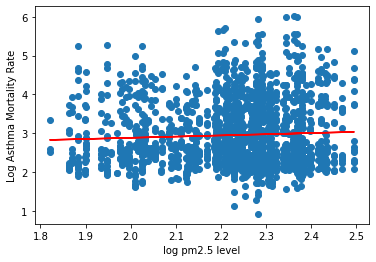

In [ ]:
mortality_only = df3[df3['Question'] == 'Asthma mortality rate']

mortality_only = mortality_only.dropna(subset=['DataValue'])
mortality_only = mortality_only.dropna(subset=['ds_pm_pred'])

x = np.log(mortality_only['ds_pm_pred'])
y = np.log(mortality_only['DataValue'])
m, b = np.polyfit(x, y, 1)

plt.scatter(x, y)
plt.plot(x, m*x + b, color = 'r')
plt.xlabel('log pm2.5 level')
plt.ylabel('Log Asthma Mortality Rate');

## GLM + Nonparametric Models

- Predicting asthma rates based on socioeconomic indicators of the demographics (age, sex, race etc.) using negative binomial regression and random forests.

- We will use random forests for our nonparametric method because random forests are great with high dimensional data, and here we have multiple features we want to account for.
- We will use negative binomial regression for our GLM because it is used for counts, and it does not restrict the mean to be equal to the variance.
- We plan to use socioeconomic indicators of demographics (age, sex, race, etc.) for our features.


Set up a prediction problem, and use both GLMs and nonparametric models to carry out your
prediction. You should identify the best choice of link function/likelihood model for your GLM, and
present results from both a frequentist and Bayesian implementation of the GLM. Similarly, you
should also choose one or two nonparametric models for prediction, and compare the results

**Methods**

– Describe what you’re trying to predict, and what features you’re using. Justify your
choices.

– Describe the GLM you’ll be using, justifying your choice. Describe any assumptions being
made by your modeling choice.

– Describe the nonparametric method(s) you’ll be using, justifying your choice. Describe
any assumptions being made by your modeling choice.

– How will you evaluate each model’s performance?


**Results**

– Summarize and interpret the results from your models.

– Estimate any uncertainty in your GLM predictions, providing clear quantitative statements of the uncertainty in plain English.


**Discussion**

– Which model performed better, and why? How confident are you in applying this to
future datasets?

– Discuss how well each model fits the data.

– Explain any differences you observed between the Bayesian and frequentist implementations of your GLM.

– Interpret the results from each model. You may choose to not provide interpretations, but you must justify this choice.

– Elaborate on the limitations of each model.

– What additional data would be useful for improving your models?

### GLM


You should identify the best choice of link function/likelihood model for your GLM, and
present results from both a frequentist and Bayesian implementation of the GLM.


- Negative binomial GLM

### Nonparametric Models

Similarly, you
should also choose one or two nonparametric models for prediction, and compare the results.

- Random Forests

In [152]:
from sklearn.tree import ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn_evaluation import plot
import seaborn as sns

In [155]:
pd.set_option('display.max_columns', None)

In [21]:
def predict_report(model, X, y):
    y_base = y
    probs = model.predict_proba(X)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y, preds)
    roc_auc = metrics.auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='GridSearchCV (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()
    classes = model.predict(X)

    accuracy = metrics.accuracy_score(classes, y)

    balanced_accuracy = metrics.balanced_accuracy_score(classes, y)

    precision = metrics.precision_score(classes, y)

    average_precision = metrics.average_precision_score(classes, y)

    f1_score = metrics.f1_score(classes, y)

    recall = metrics.recall_score(classes, y)
    print(metrics.classification_report(classes, y))
    y_i = model.predict(X)
    sensitivity = sum((y_i == 1) & (y_base == 1)) / sum(y_base==1)
    specificity = sum((y_i == 1) & (y_base == 1)) / sum(y_base==1)
    accuracy = sum(y_i == y_base) / len(y_base)
    new = '\n'
    print(f' Sensitivity : {sensitivity} {new} Specificity : {specificity} {new} Accuracy : {accuracy}')
    return y_i

In [36]:
df5.head()

,LocationAbbr,YearStart,Question,DataValue,LocationID,statefips,ds_pm_pred,Stratification1_Asian or Pacific Islander,"Stratification1_Black, non-Hispanic",Stratification1_Female,Stratification1_Hispanic,Stratification1_Male,Stratification1_Overall,"Stratification1_White, non-Hispanic"
0,AZ,2014,Asthma mortality rate,86.0,4,4,7.573242,0,0,0,0,0,1,0
1,AZ,2014,Asthma mortality rate,33.0,4,4,7.573242,0,0,0,0,1,0,0
2,AZ,2014,Asthma mortality rate,60.0,4,4,7.573242,0,0,0,0,0,0,1
3,AZ,2014,Asthma mortality rate,53.0,4,4,7.573242,0,0,1,0,0,0,0
4,GA,2014,Asthma mortality rate,58.0,13,13,10.808668,0,0,1,0,0,0,0


In [19]:
df5.columns

Index(['LocationAbbr', 'YearStart', 'Question', 'DataValue', 'LocationID',
       'ds_pm_pred', 'Stratification1_Asian or Pacific Islander',
       'Stratification1_Black, non-Hispanic', 'Stratification1_Female',
       'Stratification1_Hispanic', 'Stratification1_Male',
       'Stratification1_Overall', 'Stratification1_White, non-Hispanic'],
      dtype='object')

In [20]:
filtered_columns = ['YearStart', 'DataValue', 'LocationID',
       'ds_pm_pred', 'Stratification1_Asian or Pacific Islander',
       'Stratification1_Black, non-Hispanic', 'Stratification1_Female',
       'Stratification1_Hispanic', 'Stratification1_Male',
       'Stratification1_Overall', 'Stratification1_White, non-Hispanic']

In [21]:
x_columns = ['YearStart', 'LocationID',
       'ds_pm_pred', 'Stratification1_Asian or Pacific Islander',
       'Stratification1_Black, non-Hispanic', 'Stratification1_Female',
       'Stratification1_Hispanic', 'Stratification1_Male',
       'Stratification1_Overall', 'Stratification1_White, non-Hispanic']
y_column = 'DataValue'

In [22]:
df6 = df5[filtered_columns]
df6.head()

,YearStart,DataValue,LocationID,ds_pm_pred,Stratification1_Asian or Pacific Islander,"Stratification1_Black, non-Hispanic",Stratification1_Female,Stratification1_Hispanic,Stratification1_Male,Stratification1_Overall,"Stratification1_White, non-Hispanic"
0,2014,86.0,4,7.573242,0,0,0,0,0,1,0
1,2014,33.0,4,7.573242,0,0,0,0,1,0,0
2,2014,60.0,4,7.573242,0,0,0,0,0,0,1
3,2014,53.0,4,7.573242,0,0,1,0,0,0,0
4,2014,58.0,13,10.808668,0,0,1,0,0,0,0


In [73]:
def plot_search_results(grid):
    """
    Params: 
        grid: A trained GridSearchCV object.
    """
    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    means_train = results['mean_train_score']
    stds_train = results['std_train_score']

    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
    fig.suptitle('Score per parameter')
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        y_2 = np.array(means_train[best_index])
        e_2 = np.array(stds_train[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
        ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' )
        ax[i].set_xlabel(p.upper())

    plt.legend()
    plt.show()

In [139]:
X = df6[x_columns]
y = df6[y_column]
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=0)

### Random Forest Regressor

In [75]:
pipe = Pipeline([('classifier' , RandomForestRegressor())])

In [141]:
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 500, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt'] # ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid

param_grid = [
    {'n_estimators' : n_estimators,
    # 'max_depth' : max_depth,
    'max_features' : max_features,
    'min_samples_split' : min_samples_split,
    'min_samples_leaf' : min_samples_leaf
    }
]

In [142]:
clf = GridSearchCV(RandomForestRegressor(max_depth=100, bootstrap=True, max_features='auto'), 
                   param_grid = param_grid, 
                   cv = 5,
                   verbose=10,
                   return_train_score = True,
                   n_jobs=14)

In [143]:
best_rf = clf.fit(X_train, y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


In [144]:
print("\nBest parameters set found over cross-validation:\n")
print(best_rf.best_params_)


Best parameters set found over cross-validation:

{'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 64}


In [145]:
best_rf_results = pd.DataFrame(best_rf.cv_results_)

In [146]:
best_rf_results.to_csv('best_rf_results.csv')

<AxesSubplot:title={'center':'Grid search results'}, xlabel='n_estimators', ylabel='Mean score'>

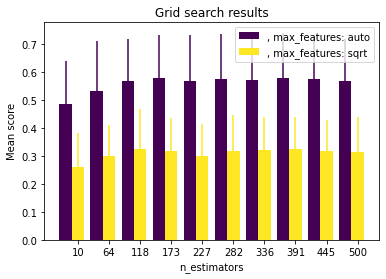

In [121]:
plot.grid_search(best_rf.cv_results_, change='n_estimators', kind='bar')

In [ ]:
best_rf_params = {'max_depth': 100, 
                  'max_features': 'auto',
                  'min_samples_leaf': 1,
                  'min_samples_split': 2,
                  'n_estimators': 118}

In [124]:
base_estimator = RandomForestRegressor(max_depth=110, n_estimators=118, bootstrap=True, max_features='auto', min_samples_leaf=1, min_samples_split=2)

In [31]:
best_rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=110, n_estimators=10)

In [32]:
y_pred = best_rf.predict(X_test)

In [122]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 14.643137254901962
Mean Squared Error: 426.6116339869282
Root Mean Squared Error: 20.654579007738896


### ADABoost Regressor

In [129]:
best_rf = RandomForestRegressor(max_depth=110, n_estimators=10, bootstrap=True, max_features='auto')

In [130]:
pipe = Pipeline([('classifier' , AdaBoostRegressor(base_estimator = base_estimator))])
                 
param_grid = {"classifier__n_estimators": [int(x) for x in np.linspace(start = 10, stop = 500, num = 10)],
              "classifier__learning_rate": [0.01, 0.1, 0.5, 0.8, 1]
             }

In [131]:
clf = GridSearchCV(pipe, 
                   param_grid = param_grid, 
                   cv = 5,
                   return_train_score = True,
                   verbose=10,
                   n_jobs=14)

In [132]:
best_clf = clf.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [133]:
print("\nBest parameters set found over cross-validation:\n")
print(best_clf.best_params_)


Best parameters set found over cross-validation:

{'classifier__learning_rate': 0.5, 'classifier__n_estimators': 118}


In [ ]:
best_abr_params = {'classifier__learning_rate': 0.5, 'classifier__n_estimators': 118}

In [134]:
y_pred = best_clf.predict(X_test)

In [135]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 15.374210701229643
Mean Squared Error: 470.1464035389125
Root Mean Squared Error: 21.682859671614178


In [137]:
abr_grid_results = pd.DataFrame(best_clf.cv_results_)

In [138]:
abr_grid_results.to_csv('abr_grid_results.csv')

### Evaluating Models

In [215]:
import joblib

#save your model or results
joblib.dump(best_rf, 'best_rf.pkl')

['best_rf.pkl']

In [ ]:
# joblib.load('best_rf.pkl')

In [156]:
best_rf_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.014002,0.001643,0.002300,0.000678,auto,1,2,10,"{'max_features': 'auto', 'min_samples_leaf': 1...",0.524990,0.587494,0.346337,0.309160,0.694957,0.492588,0.145633,19,0.892353,0.853066,0.940620,0.892399,0.902434,0.896174,0.027935
1,0.082014,0.009604,0.007602,0.001200,auto,1,2,64,"{'max_features': 'auto', 'min_samples_leaf': 1...",0.693810,0.722043,0.302439,0.560887,0.651947,0.586225,0.151998,1,0.931300,0.921170,0.958897,0.941607,0.924896,0.935574,0.013565
2,0.140224,0.007367,0.010502,0.001924,auto,1,2,118,"{'max_features': 'auto', 'min_samples_leaf': 1...",0.670215,0.710358,0.288947,0.536231,0.623710,0.565892,0.150117,9,0.929917,0.920459,0.959503,0.944707,0.910963,0.933110,0.017273
3,0.210136,0.004843,0.013102,0.002059,auto,1,2,173,"{'max_features': 'auto', 'min_samples_leaf': 1...",0.710723,0.737243,0.294123,0.521450,0.633585,0.579425,0.161144,4,0.937318,0.933563,0.957635,0.941659,0.922482,0.938531,0.011476
4,0.257245,0.006639,0.015603,0.002538,auto,1,2,227,"{'max_features': 'auto', 'min_samples_leaf': 1...",0.655787,0.750380,0.271016,0.538139,0.653873,0.573839,0.165689,6,0.926227,0.930305,0.955435,0.940241,0.919752,0.934392,0.012448


<AxesSubplot:title={'center':'Grid search results'}, xlabel='n_estimators', ylabel='Mean score'>

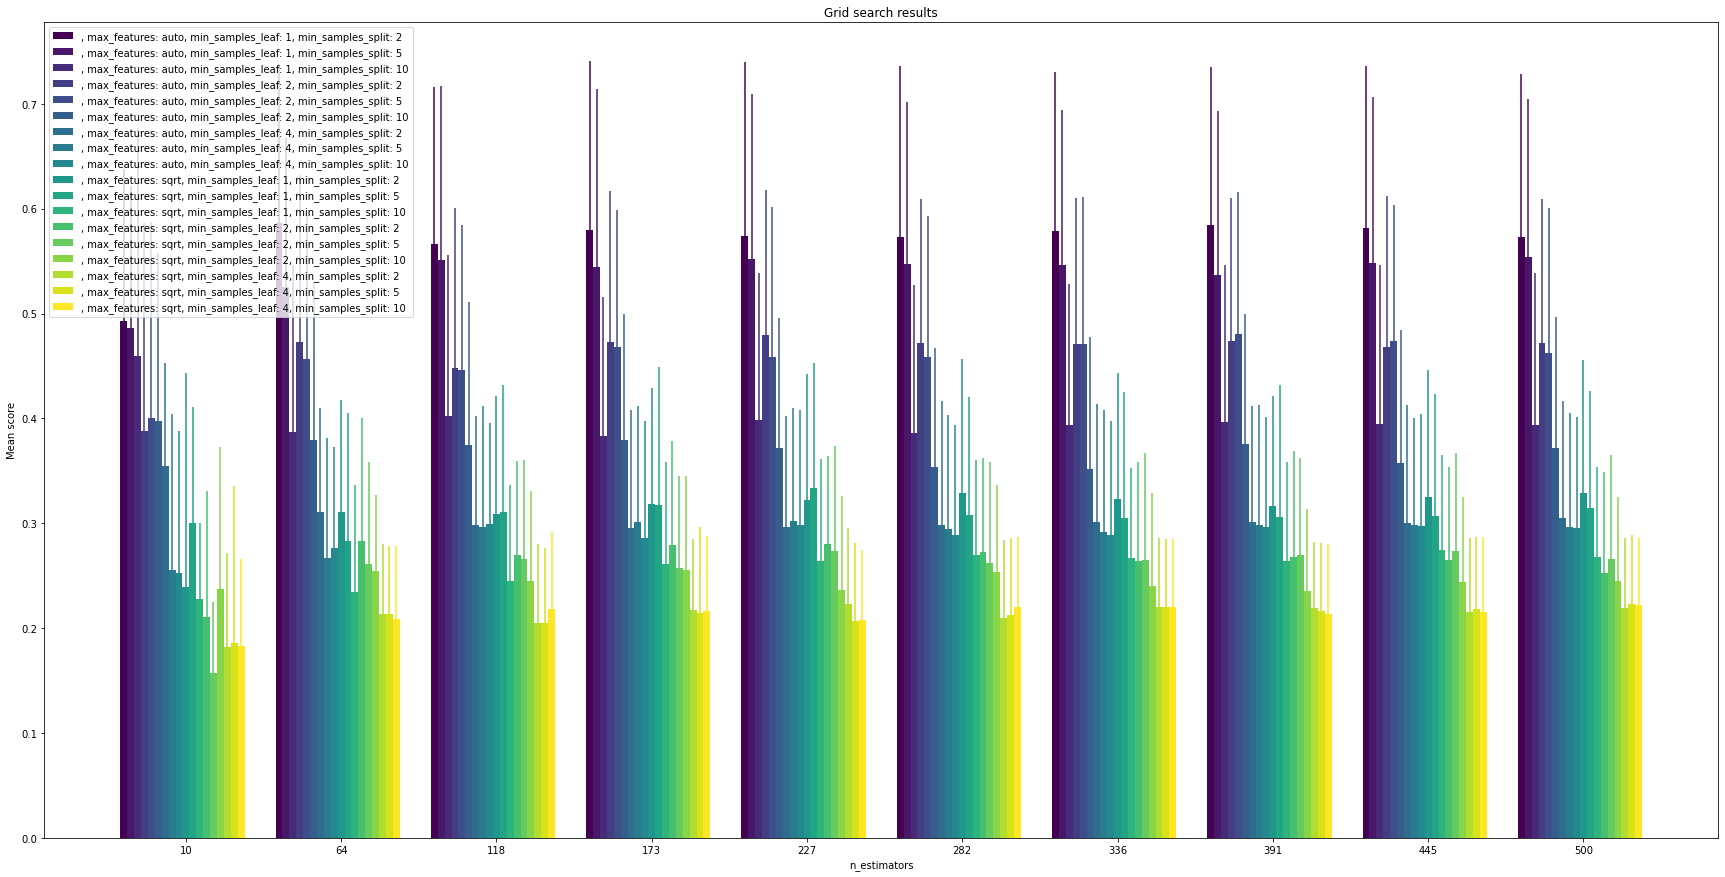

In [209]:
fig = plt.figure(figsize=(30,15))
plot.grid_search(best_rf.cv_results_, change='n_estimators', kind='bar')

C:\Users\afros\AppData\Local\Temp\ipykernel_59012\1910020440.py:2: MatplotlibDeprecationWarning: Calling add_axes() without argument is deprecated since 3.3 and will be removed two minor releases later. You may want to use add_subplot() instead.
  ax = fig.add_axes()


<AxesSubplot:xlabel='Num. Estimators', ylabel='Mean Train Score'>

<Figure size 720x360 with 0 Axes>

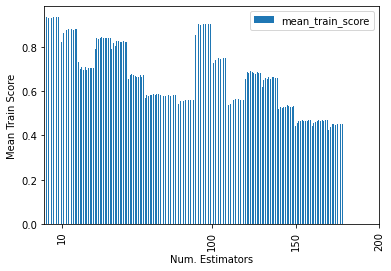

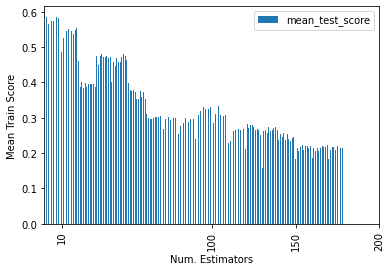

In [201]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes()

best_rf_results.plot(kind='bar', x='param_n_estimators', y='mean_train_score', 
                     stacked=False, xticks=[10, 100, 150, 200],
                    xlabel='Num. Estimators',
                    ylabel='Mean Train Score')
best_rf_results.plot(kind='bar', x='param_n_estimators', y='mean_test_score', 
                     stacked=False, xticks=[10, 100, 150, 200],
                    xlabel='Num. Estimators',
                     ylabel='Mean Train Score'
                    )

In [175]:
abr_grid_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__learning_rate,param_classifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.324331,0.017049,0.071613,0.005390,0.01,10,"{'classifier__learning_rate': 0.01, 'classifie...",0.611960,0.691535,0.277179,0.378357,0.562647,0.504335,0.153295,50,0.895221,0.898721,0.923515,0.896939,0.880245,0.898928,0.013938
1,8.635001,0.043114,0.441377,0.009990,0.01,64,"{'classifier__learning_rate': 0.01, 'classifie...",0.658172,0.724588,0.290257,0.480493,0.591179,0.548938,0.152427,48,0.937193,0.940592,0.963224,0.947430,0.934325,0.944553,0.010309
2,15.900865,0.065873,0.846147,0.023300,0.01,118,"{'classifier__learning_rate': 0.01, 'classifie...",0.745365,0.735939,0.311405,0.532631,0.674019,0.599872,0.163043,47,0.956751,0.952744,0.967958,0.959966,0.948947,0.957273,0.006504
3,23.194633,0.169942,1.352135,0.037919,0.01,173,"{'classifier__learning_rate': 0.01, 'classifie...",0.760954,0.770923,0.318539,0.563265,0.688731,0.620482,0.168206,46,0.962256,0.963286,0.972611,0.966879,0.957227,0.964452,0.005116
4,30.542511,0.186268,1.664789,0.022472,0.01,227,"{'classifier__learning_rate': 0.01, 'classifie...",0.780568,0.772665,0.344230,0.590857,0.718499,0.641364,0.163344,45,0.967485,0.971581,0.976340,0.972435,0.963805,0.970329,0.004308


C:\Users\afros\AppData\Local\Temp\ipykernel_59012\921494291.py:2: MatplotlibDeprecationWarning: Calling add_axes() without argument is deprecated since 3.3 and will be removed two minor releases later. You may want to use add_subplot() instead.
  ax = fig.add_axes()
C:\Users\afros\anaconda3\lib\site-packages\pandas\core\indexes\base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


<AxesSubplot:xlabel='Num. Estimators', ylabel='Mean Train Score'>

<Figure size 720x360 with 0 Axes>

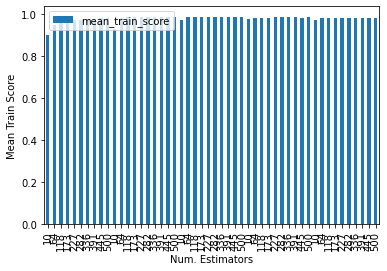

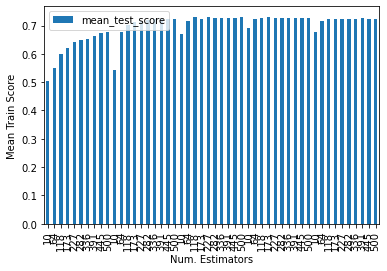

In [206]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes()

abr_grid_results.plot(kind='bar', x='param_classifier__n_estimators', y='mean_train_score', 
                     stacked=False,
                    xlabel='Num. Estimators',
                    ylabel='Mean Train Score')
abr_grid_results.plot(kind='bar', x='param_classifier__n_estimators', y='mean_test_score', 
                     stacked=False,
                    xlabel='Num. Estimators',
                     ylabel='Mean Train Score'
                    )

<AxesSubplot:title={'center':'Grid search results'}, xlabel='classifier__n_estimators', ylabel='Mean score'>

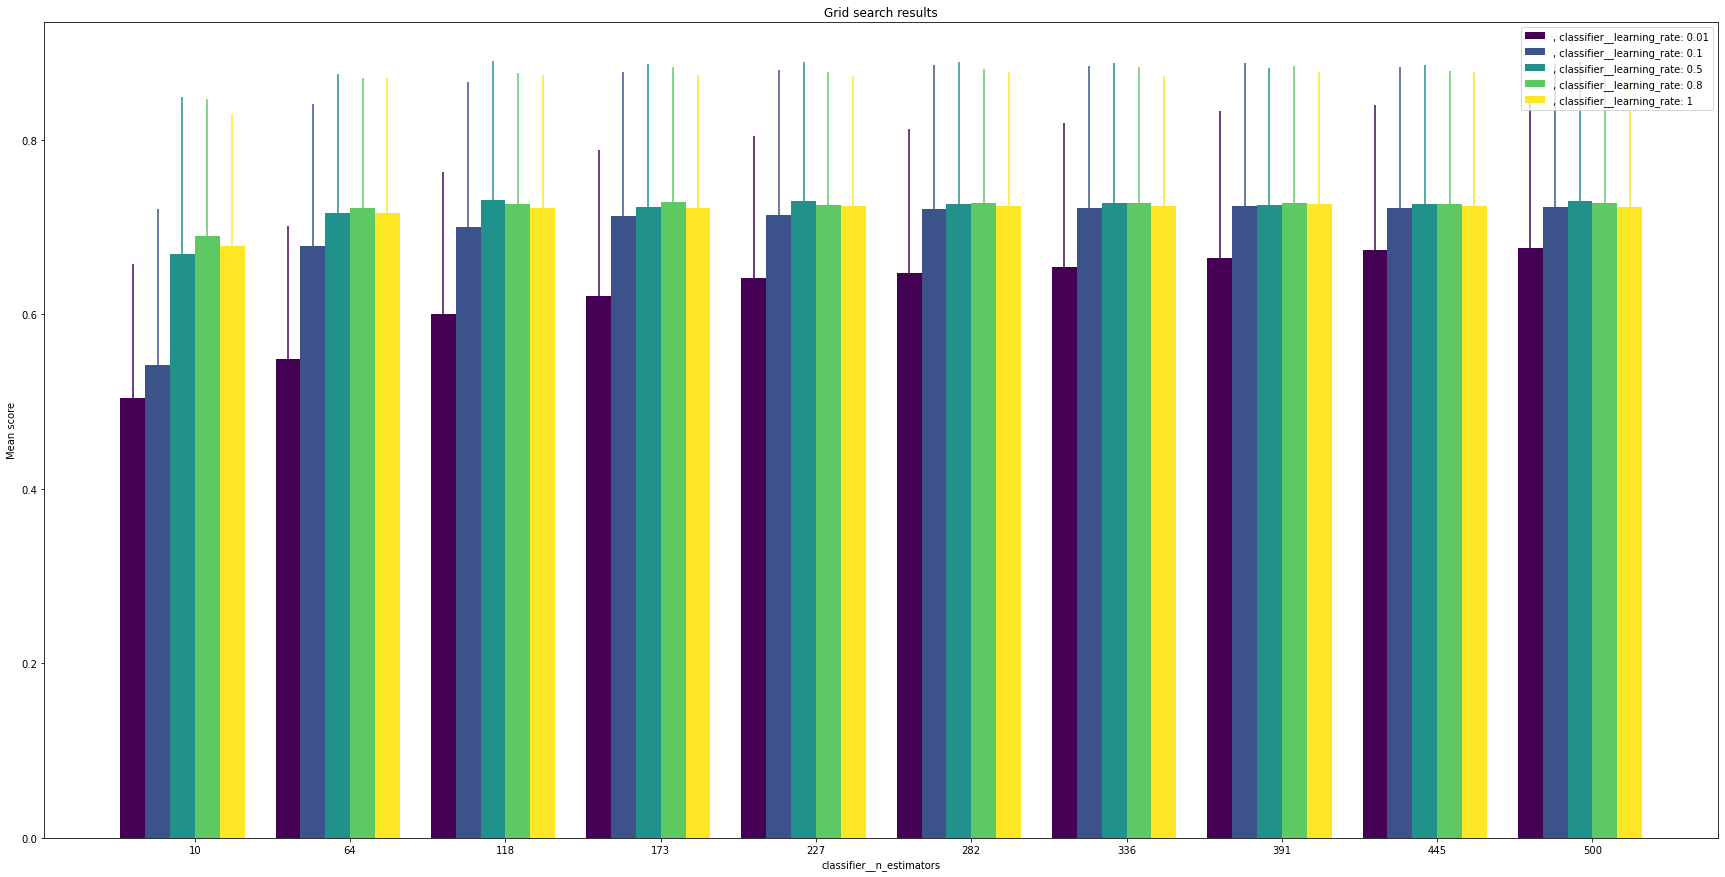

In [214]:
fig = plt.figure(figsize=(30,15))
plot.grid_search(best_clf.cv_results_, change='classifier__n_estimators', kind='bar')

In [216]:
joblib.dump(best_clf, 'best_clf.pkl')

['best_clf.pkl']

In [217]:
# joblib.load('best_clf.pkl')

In [218]:
y_pred = best_rf.predict(X_test)

In [219]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 16.73406862745098
Mean Squared Error: 599.0229204963235
Root Mean Squared Error: 24.474944749607168


In [220]:
y_pred = best_clf.predict(X_test)

In [221]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 15.374210701229643
Mean Squared Error: 470.1464035389125
Root Mean Squared Error: 21.682859671614178


In [223]:
best_clf.cv_results_

{'mean_fit_time': array([ 1.32433052,  8.63500128, 15.90086541, 23.19463291, 30.54251075,
        38.35696816, 46.40986872, 54.17891932, 60.44270902, 67.37381396,
         1.40654469,  8.84763794, 16.17511253, 23.46487975, 27.33215523,
        36.20139384, 43.89713168, 52.1299624 , 59.2831068 , 66.92093477,
         1.28212271,  8.3997601 , 15.96357479, 22.52541642, 28.74809847,
        35.97385416, 42.48268628, 48.86779575, 55.5833631 , 63.12387462,
         1.27372169,  7.78335319, 14.72515984, 22.01152673, 29.23108182,
        36.20699458, 42.87755485, 50.03589883, 57.13513355, 64.0513351 ,
         1.38123994,  7.85266485, 14.99970737, 21.67526813, 27.21173077,
        34.02871552, 40.60966072, 46.58369908, 50.56779137, 53.14543967]),
 'std_fit_time': array([0.01704862, 0.04311351, 0.06587312, 0.16994153, 0.18626849,
        0.17849024, 0.16800792, 0.25245428, 0.66866989, 0.81056282,
        0.01602919, 0.07440059, 0.29464084, 0.72497049, 0.88387645,
        0.31817308, 0.52357694,

<AxesSubplot:>

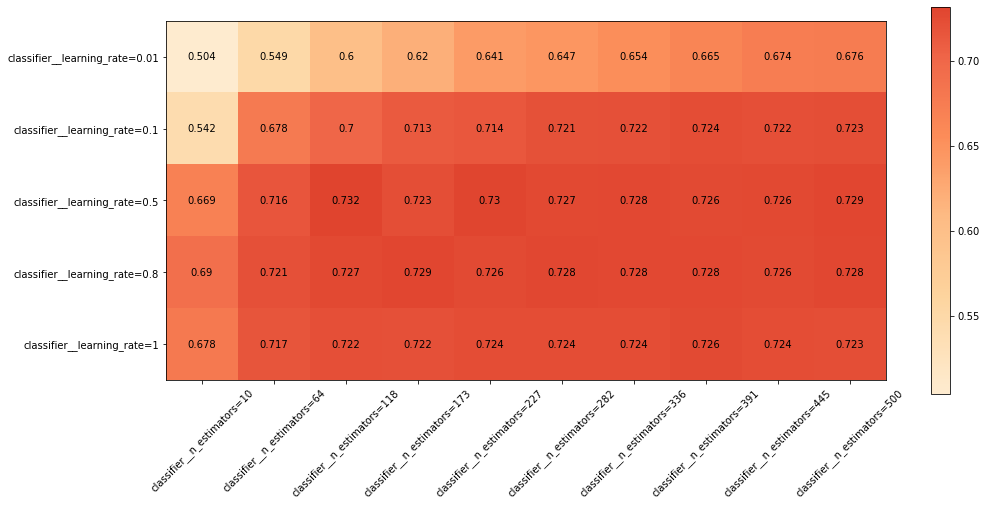

In [232]:
fig = plt.figure(figsize=(15,7))
plot.grid_search(best_clf.cv_results_, change=('classifier__n_estimators', 'classifier__learning_rate'))